# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error #MSE

#ПРОСТО ИЗ ЛЮБОПЫТСТВА ПРОБОВАЛ ДРУГОЙ АЛГОРИТМ
#from sklearn.ensemble import RandomForestRegressor

In [2]:
reg_0 = pd.read_csv('/datasets/geo_data_0.csv')#, sep='\t')
reg_1 = pd.read_csv('/datasets/geo_data_1.csv')#, sep='\t')
reg_2 = pd.read_csv('/datasets/geo_data_2.csv')#, sep='\t')

In [3]:
reg_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
reg_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
reg_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Для дальнейшего удобства обозначим соответствующие регионы (датасеты), и связанные с ними расчеты, как:
- "Регион 0"
- "Регион 1"
- "Регион 2"

In [6]:
reg_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет. Данные храняться в соответствующих форматах.

In [7]:
reg_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

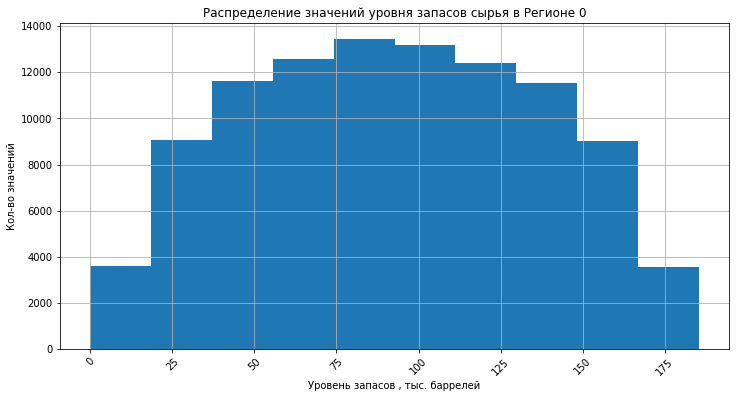

In [8]:
reg_0['product'].plot(kind='hist', grid=True, rot=45,figsize=(12,6))
plt.title("Распределение значений уровня запасов сырья в Регионе 0")
plt.ylabel("Кол-во значений")
plt.xlabel('Уровень запасов , тыс. баррелей')
plt.show()

Распределение целевого параметра 'product' для Региона 0 довольно близко к нормальному. Медианное и среднее значения близки. Т.е. в большинстве скважин запасы оценены в диапазоне от 56 до 128 тыс. баррелей.

In [9]:
reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет. Данные храняться в соответствующих форматах.

In [10]:
reg_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

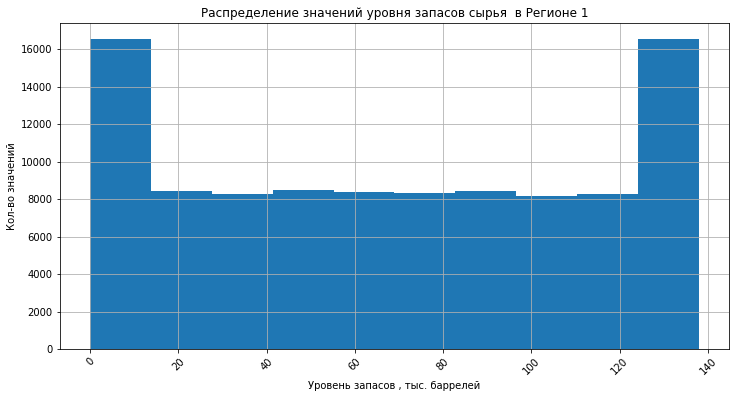

In [11]:
reg_1['product'].plot(kind='hist', grid=True, rot=45,figsize=(12,6))
plt.title("Распределение значений уровня запасов сырья  в Регионе 1")
plt.ylabel("Кол-во значений")
plt.xlabel('Уровень запасов , тыс. баррелей')
plt.show()

Распределение целевого параметра 'product' для Региона 1 очень специфическое. Медианное и среднее значения заметно отличаются (разница около 20%). Значения очевидно распределяются в трех зонах: 
- одна часть (левый пик) расположена в диапазоне от 0 до примерно 18 тыс. баррелей.;
- вторая часть (правый пик) расположена в диапазоне от примерно 125 до 140 тыс. баррелей.
- третья, самая большая, часть распределена примерно "ровным слоем" в кол-ве по 8.1 тыс. значений в диапазоне от 18 до 125 тыс. баррелей  

In [12]:
reg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет. Данные храняться в соответствующих форматах.

In [13]:
reg_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

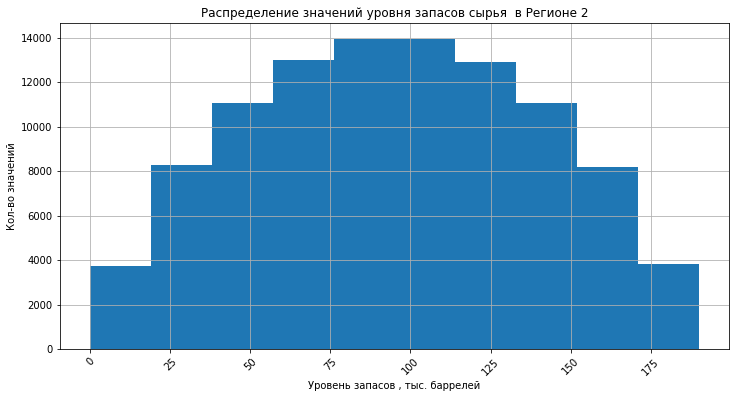

In [14]:
reg_2['product'].plot(kind='hist', grid=True, rot=45,figsize=(12,6))
plt.title("Распределение значений уровня запасов сырья  в Регионе 2")
plt.ylabel("Кол-во значений")
plt.xlabel('Уровень запасов , тыс. баррелей')
plt.show()

Распределение целевого параметра 'product' для Региона 2 также довольно близко к нормальному. Медианное и среднее значения близки. Т.е. в большинстве скважин запасы оценены в диапазоне от 59 до 130 тыс. баррелей.

__Итак.__ Для моделирования представлены три датасета по 100 тыс. записей.

Датасеты не содержат пропусков, не требуют дополнительной предобработки для обучения. 

По условиям проекта значения параметров f0,f1,f2 не раскрываются, поэтому сделать заключение о качестве данных не представляется возможным.

Параметр "product" во всех трех датасетах не содержит аномальных значений.

Таким образом, можно переходить к обучению моделей.

## Обучение и проверка модели

Для начала подготовим сводную таблицу для будущих результатов расчетов для регионов. С ней удобней будет анализировать результаты и делать выводы.

In [15]:
region_pivot=pd.DataFrame(index=['Регион 0', 'Регион 1','Регион 2'], 
                          columns=['Средний "валидный" запас сырья','Средний оценочный (предсказанный) запас сырья','RMSE'])
#region_pivot

Подготовим функцию, которая формирует учебные и пр. наборы, учит модели и выдаёт результаты валидации.

In [16]:
#прогнозирование запасов в скважинах
# функция принимает датасет с показателями по региону (data) и название региона (reg)

def data_prep(data,reg):
    #обучающие признаки
    features = data.drop(['id','product'], axis=1)
    #целевой признак
    target = data['product']
    
    #формируем обучающий и валидный наборы данных
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size= 0.75, random_state=54321)
    
    # печатаем размеры обучающих и валидных наборов для контроля
    print('РАСЧЕТЫ ПО РЕГИОНУ:', reg)
    print('---------------------------------------------------------------------')
    print('Обучающие признаки:',features_train.shape)
    print('Обучающая валидация:',features_valid.shape)

    print('Обучающий целевой признак:',target_train.shape)
    print('Обучающая целевая валидация:',target_valid.shape)
    
      
    #ПРОСТО ИЗ ЛЮБОПЫТСТВА ПРОБОВАЛ ДРУГОЙ АЛГОРИТМ 
    #lr = RandomForestRegressor(n_estimators=100, 
                          #criterion='mse', 
                          #max_depth=6, 
                          #n_jobs=-1, 
                          #random_state=12345, 
                          #)
    
    #учим модель регрессии
    lr = LinearRegression(n_jobs=-1)
    lr.fit(features_train, target_train)
    
    #получаем предсказания
    predicted_valid = lr.predict(features_valid)

    # рассчитываем RMSE
    rmse = round(mean_squared_error(target_valid, predicted_valid)**0.5,2)
    
    #рассчитываем средний прогнозируемый объем запасов
     #прогнозируемый средний запас нефти
    estim_mean_resourses=round(predicted_valid.mean(),2)
     #"валидный" средний запас нефти
    valid_mean_resourses=round(target_valid.mean(),2)
    
    # печатаем результаты прогнозирования
    print('---------------------------------------------------------------------')
    print('Средний "валидный" запас сырья, тыс. баррелей', reg,':', round(valid_mean_resourses,2))
    print('Средний оценочный (предсказанный) запас сырья, тыс. баррелей', reg,':', round(estim_mean_resourses,2))
    print('RMSE',reg,':', round(rmse,2))
    print() 
    print('Статистические характеристики полученных предсказаний')
    print(pd.Series(predicted_valid).describe())
    print()
    print('График распределения прогнозных значений запаса сырья в скважине')
    
    # выводим график распределния прогнозных значений
    pd.Series(predicted_valid).hist()
    
   
    
    # возвращаем средний прогнозируемый запас, средний "валидный" запас, RMSE, 
    # предсказания по региону и валидационный набор по региону
    return estim_mean_resourses,  valid_mean_resourses,  rmse, predicted_valid, target_valid

Переходим к расчету результатов для каждого региона

### Регион "0"

РАСЧЕТЫ ПО РЕГИОНУ: "Регион 0"
---------------------------------------------------------------------
Обучающие признаки: (75000, 3)
Обучающая валидация: (25000, 3)
Обучающий целевой признак: (75000,)
Обучающая целевая валидация: (25000,)
---------------------------------------------------------------------
Средний "валидный" запас сырья, тыс. баррелей "Регион 0" : 92.58
Средний оценочный (предсказанный) запас сырья, тыс. баррелей "Регион 0" : 92.16
RMSE "Регион 0" : 37.68

Статистические характеристики полученных предсказаний
count    25000.000000
mean        92.159212
std         23.285735
min        -10.136645
25%         76.391201
50%         92.335147
75%        107.862862
max        176.187650
dtype: float64

График распределения прогнозных значений запаса сырья в скважине


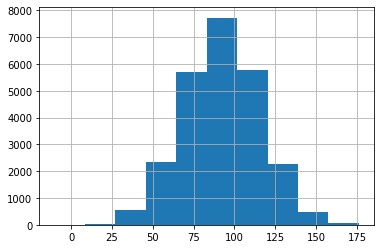

In [17]:
estim_maen_resourses_0, valid_mean_resourses_0, rmse_reg_0, pred_0, target_0 = data_prep(reg_0,'"Регион 0"')
region_pivot.loc['Регион 0','Средний "валидный" запас сырья']= valid_mean_resourses_0
region_pivot.loc['Регион 0','Средний оценочный (предсказанный) запас сырья']= estim_maen_resourses_0
region_pivot.loc['Регион 0','RMSE']= rmse_reg_0

Распределение полученных прогнозных запасов в Регионе 0 довольно близко к нормальному. Медианное и средние значения запасов сырья очень близки. Обращают на себя внимание отрицательные значения прогноза, что естественно противоречит природе вещей, т.к. речь идет о прогнозе физического кол-ва нефти. 

### Регион "1"

РАСЧЕТЫ ПО РЕГИОНУ: "Регион 1"
---------------------------------------------------------------------
Обучающие признаки: (75000, 3)
Обучающая валидация: (25000, 3)
Обучающий целевой признак: (75000,)
Обучающая целевая валидация: (25000,)
---------------------------------------------------------------------
Средний "валидный" запас сырья, тыс. баррелей "Регион 1" : 68.44
Средний оценочный (предсказанный) запас сырья, тыс. баррелей "Регион 1" : 68.45
RMSE "Регион 1" : 0.89

Статистические характеристики полученных предсказаний
count    25000.000000
mean        68.445941
std         45.886833
min         -1.917073
25%         28.502290
50%         57.740097
75%        109.262062
max        139.525949
dtype: float64

График распределения прогнозных значений запаса сырья в скважине


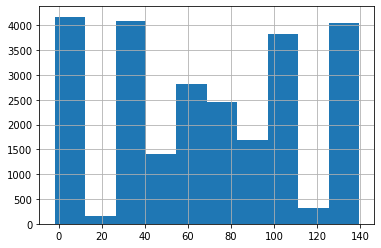

In [18]:
estim_maen_resourses_1, valid_mean_resourses_1, rmse_reg_1, pred_1, target_1  = data_prep(reg_1,'"Регион 1"')
region_pivot.loc['Регион 1','Средний "валидный" запас сырья']= valid_mean_resourses_1
region_pivot.loc['Регион 1','Средний оценочный (предсказанный) запас сырья']= estim_maen_resourses_1
region_pivot.loc['Регион 1','RMSE']= rmse_reg_1

Распределение полученных прогнозных запасов в Регионе 1 очень специфическое. Явно выражены кластеры: диапазоны запасов, в которых Формируются пиковые значения. 

Например, "кластер 125-140 тыс. баррелей", в котором порядка 4 тыс. прогнозных результатов. 
Еще "кластер 27-40 тыс. баррелей", в котором также около 4 тыс. прогнозных результатов.
И т.д. 

Т.е. Регион 1 какой-то "ненормальный" в плане распределения запасов.

###  Регион "2"

РАСЧЕТЫ ПО РЕГИОНУ: "Регион 2"
---------------------------------------------------------------------
Обучающие признаки: (75000, 3)
Обучающая валидация: (25000, 3)
Обучающий целевой признак: (75000,)
Обучающая целевая валидация: (25000,)
---------------------------------------------------------------------
Средний "валидный" запас сырья, тыс. баррелей "Регион 2" : 95.08
Средний оценочный (предсказанный) запас сырья, тыс. баррелей "Регион 2" : 94.92
RMSE "Регион 2" : 40.15

Статистические характеристики полученных предсказаний
count    25000.000000
mean        94.922295
std         19.852319
min         14.291189
25%         81.332496
50%         94.825128
75%        108.546305
max        176.150855
dtype: float64

График распределения прогнозных значений запаса сырья в скважине


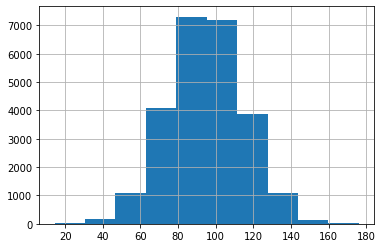

In [19]:
estim_maen_resourses_2, valid_mean_resourses_2, rmse_reg_2, pred_2, target_2  = data_prep(reg_2,'"Регион 2"')
region_pivot.loc['Регион 2','Средний "валидный" запас сырья']= valid_mean_resourses_2
region_pivot.loc['Регион 2','Средний оценочный (предсказанный) запас сырья']= estim_maen_resourses_2
region_pivot.loc['Регион 2','RMSE']= rmse_reg_2

Распределение полученных прогнозных запасов в Регионе 2 также довольно близко к нормальному. Медианное и средние значения запасов сырья очень близки. Аномальных значений, отрицательных прогнозов, нет.

**Выводы:**

In [20]:
# сводная таблица по регионам
region_pivot

,"Средний ""валидный"" запас сырья",Средний оценочный (предсказанный) запас сырья,RMSE
Регион 0,92.58,92.16,37.68
Регион 1,68.44,68.45,0.89
Регион 2,95.08,94.92,40.15


Очевидно, что лучшие результаты даёт модель для Региона 1 (минимальная RMSE). При этом средний прогнозируемый уровень запасов в Регионе 1 наименьший.  Да и сам Регион 1, как было показано выше, какой-то "ненормальный".

Максимальный прогнозируемый уровень запасов в Регионе 2. Однако качество прогноза модели для Региона 2 нихудшее из трёх регионов (максимальная RMSE).

Прогнозируемые запасы в Регионах 0 и 2, как было показано выше, распределены очень близко к нормальному распределению.

## Подготовка к расчёту прибыли

Установим экономические показатели (константы):

In [21]:
#доход от продажи 1 тыс. баррелей
REVENUE_PER_BARREL=450

In [22]:
# планируемое кол-во разрабатываемых скважин
OILWELLS=200

In [23]:
# максимальный риск убытков
MAX_LOSS_RISK=0.025

In [24]:
#бюджет на разработку скважин в регионе
OILWELLS_BUDJET=10000000000

Т.к. в регионе планируется разрабатывать 200 скважин, при бюджете на разработку 10 млрд. руб., то на одну скважину приходится в среднем ...

In [25]:
OILWELLS_BUDJET/OILWELLS/1000000 #результат в млн.

50.0

... 50 млн. руб.инвестиций.
При цене 450 руб. за 1 баррель, __чтобы покрыть инвестиции, каждая разрабатываемая скважина должна дать в среднем не менее...__

In [26]:
MIN_RES=round((OILWELLS_BUDJET/OILWELLS)/REVENUE_PER_BARREL/1000,2)
MIN_RES

111.11

__.. 111,(11) тыс. баррелей нефти.__ Посмотрим снова на полученные прогнозные запасы нефти по регионам:

In [27]:
# сводная таблица по регионам
region_pivot['Дефицит запаса, %'] =(1-region_pivot['Средний оценочный (предсказанный) запас сырья']/MIN_RES)*100
#столбец для расчета дефицита нефти в сважинах по сравнению с минимально рентабельным
region_pivot['Дефицит запаса, %']=region_pivot['Дефицит запаса, %'].apply(round)
region_pivot

,"Средний ""валидный"" запас сырья",Средний оценочный (предсказанный) запас сырья,RMSE,"Дефицит запаса, %"
Регион 0,92.58,92.16,37.68,17
Регион 1,68.44,68.45,0.89,38
Регион 2,95.08,94.92,40.15,15


Очевидно, что средние прогнозируемые запасы нефти в регионах на более чем 15% меньше, чем минимально рентабельный уровень запаса.

Итак. Подготовительные расчеты показывают, что __ни один из трех исследуемых регионов, по своим средним прогнозным показателям, не обеспечит получение прибыли__ от разработки нефтяных месторождений. 

Т.е. необходимо провести более тщательный анализ, чтобы подтвердить или опровергнуть, полученный промежуточный вывод.

## Расчёт прибыли и рисков 

Для начала подготовим функции для:

    - расчета прибыли от месторождения из 'count' скважин;
    - для проведения процедуры bootstrap;
    - для оценки риска получения убытков.

In [28]:
#расчет прибыли месторождения 
def profit(predicted,target,count,price):
       
    #сортируем прогнозы по убыванию
    probs_sorted = predicted.sort_values(ascending=False) # ВОТ ИЗ-ЗА ЭТОГО ХВОСТА Я ПОДОЗРЕВАЮ БЫЛА БЕДА .head(count)
    
    # формируем соответсвующую выборку целевых параметров 
    selected = target[probs_sorted.index][:count] #ВОТ ЭТОТ "ХВОСТ" ДОБАВИЛ
     
    #рассчитываем прибыль месторождения
    prof = round(((price * selected.sum()*1000-OILWELLS_BUDJET)/1000000),0)
    
    #ВСТАВКА ДЛЯ ПРОВЕРКИ ОШИБКИ
    if selected.shape!=(200,):
        print('--------------------------------------------------------')
       #print('Размер отсортированных предсказанных значений:',probs_sorted.shape)
        print('Размер соответствующих целевых значений:',selected.shape)
        print('--------------------------------------------------------')
        
    return prof#, mean, lower

In [29]:
#бутстрап 
def bootstrap(targ,pred,reg): #targ-целевой признак и pred-предсказания по региону-reg
    values =[] #хранилище для значений прогнозной прибыли 
    
    state = np.random.RandomState(54321) 
    pred = pd.Series(pred)
    targ = targ.reset_index(drop=True)
    
    #цикл для формирования тестовых выборок
    for i in range(1000):   
        #формируем случайную выборку 500 скважин из прогнозного датасета по региону
        target_subsample = targ.sample(n=500, replace=True, random_state=state)
        
        #print('размер буста из targeta', target_subsample.shape)
        
        #отбираем соответсвующие значения целевого параметра 'product'
        probs_subsample = pred[target_subsample.index] 
        
        #print('размер буста из предсказаний', probs_subsample.shape)
        
        
        #расчитываем прибыль для тестовой выборки и записываем в хранилище
        values.append(profit(probs_subsample,target_subsample,OILWELLS,REVENUE_PER_BARREL))
       
    values = pd.Series(values)
    #2.5% квантиль
    lower =  round(values.quantile(0.025),2)
    
    print('РАСЧЕТЫ ПО РЕГИОНУ:', reg)
    print('---------------------------------------------------------------------')

    mean = values.mean()
    #print('------------------------')
    print("Средняя прогнозная прибыль, млн. руб.:", mean)
    print("2.5%-квантиль, млн. руб.:", lower)

    #ВСТАВКА 97.5% квантиля 
    higher =  round(values.quantile(0.975),2)
    print("97.5%-квантиль, млн. руб.:", higher)
    
    #СТАРЫЙ ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ЗАКОМЕНТИЛ
    #confidence_interval = st.t.interval(0.95, len(values)-1, mean, values.sem())
    #confid=[round(confidence_interval[0],2),round(confidence_interval[1],2)]
    
    #НОВЫЙ ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ
    confid=[lower,higher]
    print("95%-ый доверительный интервал:", confid)
    
    
    return values, round(lower,2), round(mean,2),confid

In [30]:
# оценка риска убытков
def loss_risc(data,reg): #data-предсказания прибыли для региона
    #график распределения прогнозных значений прибыли для региона reg
    data.plot(kind='hist', grid=True)
    
    # !!!!ИСПРАВЛЕННЫЙ РАСЧЕТ РИСКА УБЫТКОВ
    loss_possibility =  (data < 0).mean()*100
    
    #ЭТО УЖЕ НЕ НАДО
    #print('Кол-во отрицательных прогнозов прибыли:', loss_count)
    
    print('Риск убытков, %:',round(loss_possibility,2))
    
    #строим график распределения прогнозов прибыли
    data.plot(kind='hist', grid=True, rot=45,figsize=(12,6),bins=100,)
    plt.title("Распределение прогнозных значений прибыли "+reg)
    plt.ylabel("Кол-во значений")
    plt.xlabel('Прогнозируемая прибыль, млн.руб.')
    plt.show()
    
    return round(loss_possibility,2)

Подготовим сводную таблицу для результатов расчетов прибыли для регионов. С ней удобней будет позже анализировать результаты расчетов и делать выводы.

In [31]:
kpi=['Средняя прогнозная прибыль, млн. руб.:',
     '2.5%-квантиль, млн. руб.:',
     '95%-ый доверительный интервал, млн. руб.:', 
     'Риск убытков, %:']
region_pivot=pd.DataFrame(columns=['Показатели региона','Регион 0', 'Регион 1','Регион 2'])
region_pivot['Показатели региона']=kpi

### Расчет прибыли и рисков Регион "0"

РАСЧЕТЫ ПО РЕГИОНУ: Регион 0
---------------------------------------------------------------------
Средняя прогнозная прибыль, млн. руб.: 408.945
2.5%-квантиль, млн. руб.: -96.02
97.5%-квантиль, млн. руб.: 962.02
95%-ый доверительный интервал: [-96.02, 962.02]
Риск убытков, %: 5.2


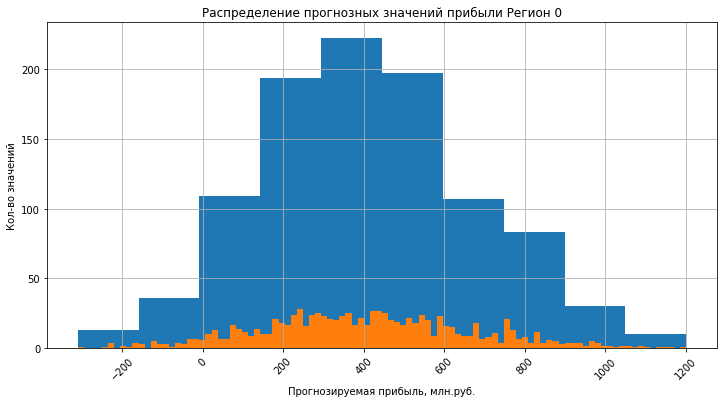

In [32]:
#вызываем бутсртап
profit_0, lower_0, mean_0, confidence_interval_0  = bootstrap(target_0, pred_0, 'Регион 0')

#считаем риски
loss_possibility_0=loss_risc(profit_0, 'Регион 0')

#добавляем результаты в сводную таблицу
region_pivot.loc[0,'Регион 0'] = mean_0
region_pivot.loc[1,'Регион 0'] = lower_0
region_pivot.loc[2,'Регион 0'] = confidence_interval_0
region_pivot.loc[3,'Регион 0'] = loss_possibility_0

### Расчет прибыли и рисков Регион "1"

РАСЧЕТЫ ПО РЕГИОНУ: Регион 1
---------------------------------------------------------------------
Средняя прогнозная прибыль, млн. руб.: 471.484
2.5%-квантиль, млн. руб.: 51.9
97.5%-квантиль, млн. руб.: 911.02
95%-ый доверительный интервал: [51.9, 911.02]
Риск убытков, %: 1.2


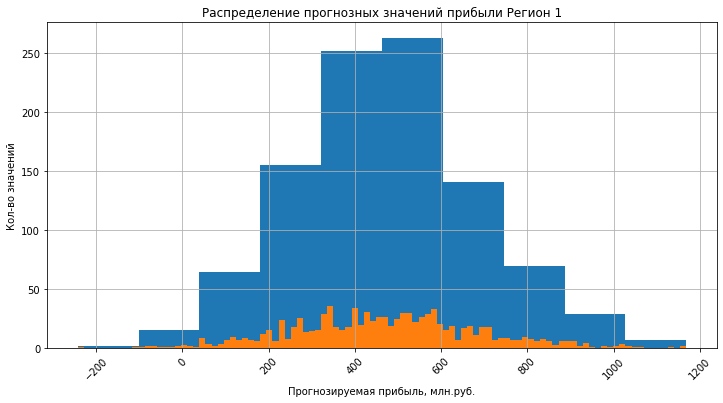

In [33]:
#вызываем бутсртап
profit_1, lower_1, mean_1, confidence_interval_1  = bootstrap(target_1, pred_1, 'Регион 1')

#считаем риски
loss_possibility_1=loss_risc(profit_1, 'Регион 1')

#добавляем результаты в сводную таблицу
region_pivot.loc[0,'Регион 1'] = mean_1
region_pivot.loc[1,'Регион 1'] = lower_1
region_pivot.loc[2,'Регион 1'] = confidence_interval_1
region_pivot.loc[3,'Регион 1'] = loss_possibility_1

### Расчет прибыли и рисков Регион "2"

РАСЧЕТЫ ПО РЕГИОНУ: Регион 2
---------------------------------------------------------------------
Средняя прогнозная прибыль, млн. руб.: 420.904
2.5%-квантиль, млн. руб.: -140.07
97.5%-квантиль, млн. руб.: 934.22
95%-ый доверительный интервал: [-140.07, 934.22]
Риск убытков, %: 7.4


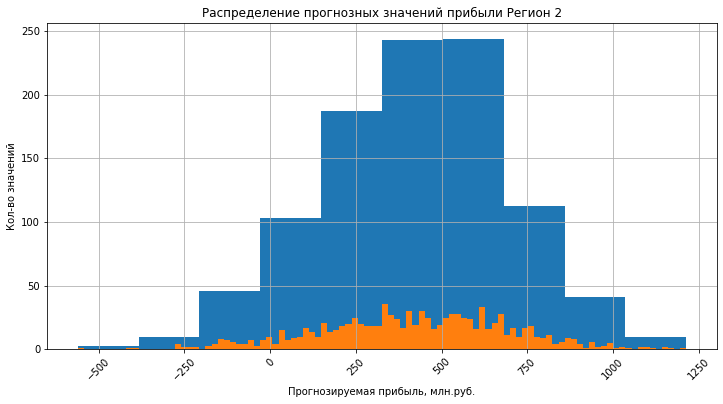

In [34]:
#вызываем бутсртап
profit_2, lower_2, mean_2, confidence_interval_2  = bootstrap(target_2, pred_2, 'Регион 2')

#считаем риски
loss_possibility_2=loss_risc(profit_2, 'Регион 2')

#добавляем результаты в сводную таблицу
region_pivot.loc[0,'Регион 2'] = mean_2
region_pivot.loc[1,'Регион 2'] = lower_2
region_pivot.loc[2,'Регион 2'] = confidence_interval_2
region_pivot.loc[3,'Регион 2'] = loss_possibility_2

## **ВЫВОД:**

In [35]:
region_pivot

,Показатели региона,Регион 0,Регион 1,Регион 2
0,"Средняя прогнозная прибыль, млн. руб.:",408.94,471.48,420.9
1,"2.5%-квантиль, млн. руб.:",-96.02,51.9,-140.07
2,"95%-ый доверительный интервал, млн. руб.:","[-96.02, 962.02]","[51.9, 911.02]","[-140.07, 934.22]"
3,"Риск убытков, %:",5.2,1.2,7.4


Как следует из полученных результатов (см. таблицу выше), по совокупности исследуемых параметров __наиболее предпочтительным является Регион 1.__

Так, расчеты показывают, что несмотря на "ненормальное" распределение запасов нефти в Регионе 1:
- прогнозируется максимальный уровень приыбли (471.48 млн. руб.);
- лучший, без отрицательных значений, доверительный интервал (51.9, 911.02);
- лучший, положительный в отличие от других регионов, 2.5% квантиль (51.9 млн. руб.); 
- минимальный риск убытков 1.2%. 

Таким образом, предварительные выводы о том, что запасы нефти в регионах не смогут обеспечить безубыточную добычу, не подтвердились. 

In [36]:
print('Спасибо за внимание!')

Спасибо за внимание!
